In [ ]:
# default_exp model_fitting

# CMR Parameter Configurations Across Lohnas & Kahana (2015) Conditions

## Initial Fitting Between Subjects
For each condition and subject, find the best fit parameters for the CMR model.

In [1]:
from compmemlearn.fitting import apply_and_concatenate, cmr_rep_objective_function
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_data
from compmemlearn.analyses import recall_probability_by_lag
import pandas as pd
from psifr import fr
from scipy.optimize import differential_evolution
from numba.typed import List
import numpy as np

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


In [2]:
from scipy.optimize import differential_evolution
from numba.typed import List

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

In [3]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model

individual_cmr_results = [[], [], [], []]

for type_index, list_type in enumerate([1, 2, 3, 4]):
    for subject in np.unique(subjects):
        print(list_type, subject)

        selection = np.logical_and(list_types == list_type, subjects == subject)

        # cost function to be minimized
        # ours scales inversely with the probability that the data could have been 
        # generated using the specified parameters and our model
        cost_function = cmr_rep_objective_function(
            trials[selection], presentations[selection], list_types[selection], list_length,
            {'sampling_rule': 0, 'familiarity_scale': 0}, free_parameters)

        individual_cmr_results[type_index].append(differential_evolution(cost_function, bounds, disp=False))
        print(individual_cmr_results[type_index][-1].fun)

1 1
691.3623304845084
1 2
409.7245595668103
1 3
689.7029729102752
1 4
280.78421251927375
1 5
666.3785601943316
1 6
636.5676462627507
1 7
322.2188418210812
1 8
599.0876232179048
1 10
467.93406325553957
1 11
843.38350089835
1 12
683.6114786387725
1 13
752.9069310420302
1 14
891.1176589653802
1 15
477.6067439984659
1 16
578.1515123883169
1 17
542.5119995178343
1 18
554.662168909182
1 19
526.2172173097242
1 20
365.0891345042936
1 21
559.3437416921147
1 22
382.89586297938934
1 23
357.3001244556459
1 24
415.52607929672996
1 25
595.0211337978393
1 27
352.24552549546763
1 28
296.3326679983501
1 29
468.0270374681567
1 30
371.869741514993
1 31
424.43149067048523
1 32
634.0782700458396
1 33
449.42242394426194
1 34
501.66640255867475
1 35
624.7500103099661
1 36
471.7830111380513
1 37
253.91365315450562
2 1
278.11609987723375
2 2
277.35397453152245
2 3
400.64797608554983
2 4
206.5585547258327
2 5
348.38081917895477
2 6
393.8016207928196
2 7
146.01200233250307
2 8
344.588338759226
2 10
274.186732275

### DataFrame Population
Next we'll build a dataframe collecting each result, subject, and condition, and the values of each corresponding fitted parameter.

In [5]:
for_df = []
list_type_labels = ['control', 'massed', 'spaced', 'mixed']

for list_type, condition in enumerate(individual_cmr_results):

    for subject_index, subject in enumerate(condition):

        for_df.append([list_type_labels[list_type], subject_index, subject.fun] + subject.x.tolist())

param_df = pd.DataFrame(for_df, columns = ['condition', 'subject', 'likelihood'] + free_parameters)
param_df.to_csv('../../data/lohnas_2014_individual_cmr_results.csv')

param_df

,condition,subject,likelihood,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity
0,control,0,691.362330,0.679099,0.839107,0.974794,0.596463,7.681364e-01,0.577182,0.025406,35.583399,0.000081,0.371448,7.652343
1,control,1,409.724560,0.729648,0.218494,0.952099,0.162925,2.220446e-16,0.759893,3.346776,0.454828,0.011046,0.266521,2.101185
2,control,2,689.702973,0.785680,0.085179,0.918903,0.055014,2.220446e-16,0.699526,6.882545,32.953614,0.007402,0.127688,1.700604
3,control,3,280.784213,0.863213,0.029265,0.994183,0.012541,2.220446e-16,0.615469,19.216419,81.201376,0.080067,0.085171,0.770609
4,control,4,666.378560,0.519969,0.997920,0.873495,0.310532,1.000000e+00,0.324756,0.082052,70.693162,0.001450,0.240264,5.104602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,mixed,30,449.909254,0.748957,0.298897,0.842510,0.052644,2.220446e-16,0.720381,19.810478,0.460363,0.017049,0.165260,0.918335
136,mixed,31,519.560434,0.857300,0.113571,0.984507,0.025417,2.220446e-16,0.364365,10.454152,0.176821,0.008535,0.134226,1.129899
137,mixed,32,510.900754,0.857690,0.580328,0.994924,0.026554,1.000000e+00,0.434287,1.570826,76.934815,0.005004,0.215064,1.093676
138,mixed,33,484.828553,0.863808,0.813556,0.995126,0.032761,5.991799e-01,0.883617,10.802007,32.548699,0.012248,0.160949,0.692827


### Visualization

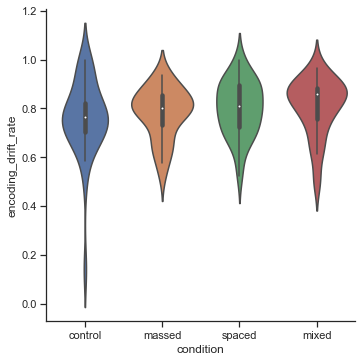

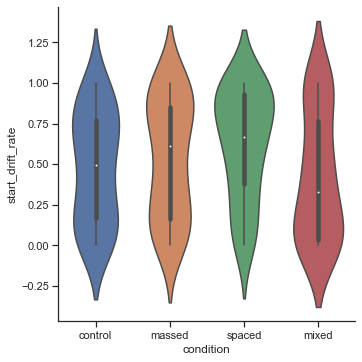

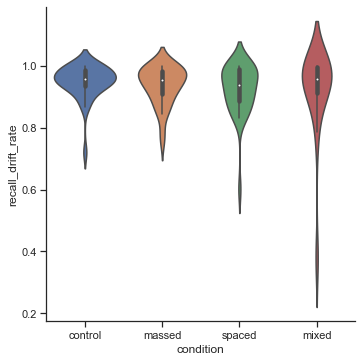

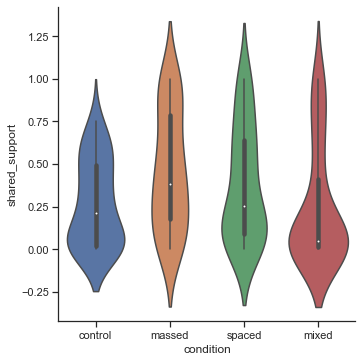

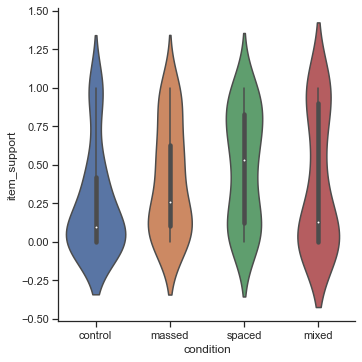

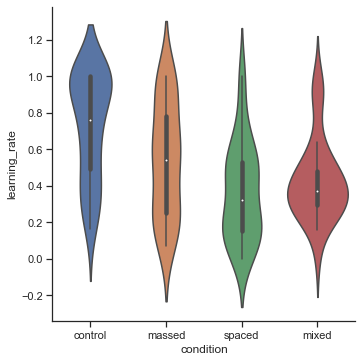

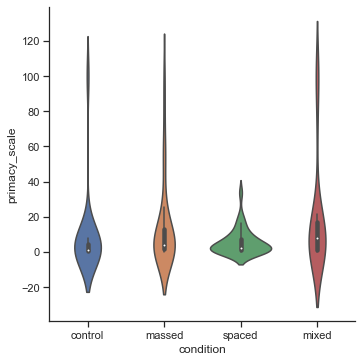

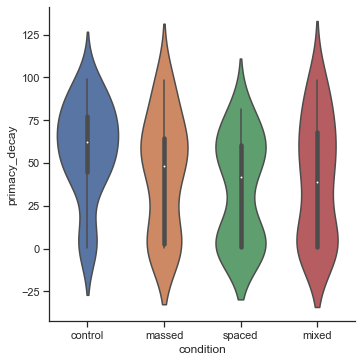

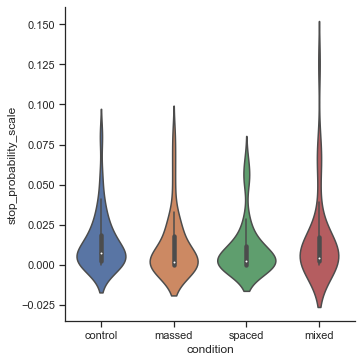

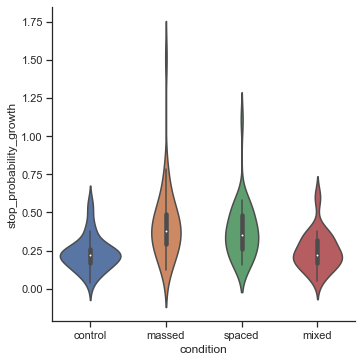

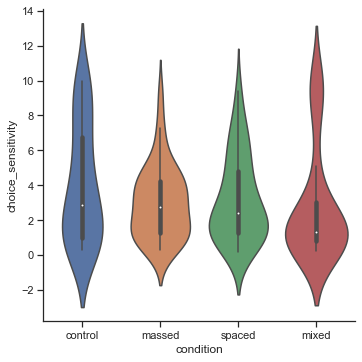

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

param_df = pd.read_csv('../../data/lohnas_2014_individual_cmr_results.csv')

sns.set_theme(style="ticks")

for parameter in free_parameters:
    g = sns.catplot(x="condition", y=parameter, data=param_df, kind='violin')
    plt.show()

## Overall Fits Between Condition

In [ ]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model

overall_cmr_results = []

for type_index, list_type in enumerate([1, 2, 3, 4]):
    print(list_type)

    selection = list_types == list_type

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = cmr_rep_objective_function(
        trials[selection], presentations[selection], list_types[selection], list_length,
        {'sampling_rule': 0}, free_parameters)

    overall_cmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(overall_cmr_results[-1].fun)

In [11]:
for_df = []
list_type_labels = ['control', 'massed', 'spaced', 'mixed']

for list_type, condition in enumerate(overall_cmr_results):

    for_df.append([list_type_labels[list_type], condition.fun] + condition.x.tolist())

overall_param_df = pd.DataFrame(for_df, columns = ['condition', 'likelihood'] + free_parameters)

overall_param_df.to_csv('../../data/lohnas_2014_overall_cmr_results.csv')
overall_param_df

,condition,likelihood,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity
0,control,18795.372091,0.733254,0.550905,0.928145,0.344581,2.220446e-16,0.934871,0.726620,0.930150,0.023617,0.091230,5.026868
1,massed,11599.828817,0.867735,0.701976,0.924563,1.000000,2.220446e-16,1.000000,1.574235,81.369837,0.010622,0.208775,6.619074
2,spaced,12384.601634,0.762635,0.785448,0.902730,0.979043,7.792533e-01,0.341264,1.498594,0.311183,0.008010,0.219261,6.189138
3,mixed,17287.452536,0.844916,0.612784,0.973164,0.045121,2.220446e-16,0.489477,2.022636,20.485787,0.021394,0.106825,1.268607


In [7]:
# export
 
def extended_apply_and_concatenate(function, dfs, contrast_name='contrast', labels='AB'):
    """
    Concatenates the results of a function applied to passed dataframes and creates a new column identifying the contrast.
    """
    return pd.concat([function(df) for df in dfs], keys=labels, names=[contrast_name]).reset_index()

In [34]:
from compmemlearn.models import Classic_CMR

model0 = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[0].x[i] for i in range(len(overall_cmr_results[0].x))}})

model1 = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[1].x[i] for i in range(len(overall_cmr_results[1].x))}})

model2 = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[2].x[i] for i in range(len(overall_cmr_results[2].x))}})

model3 = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[3].x[i] for i in range(len(overall_cmr_results[3].x))}})

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)
sim_df3 = simulate_data(model3, 1000)

dfs = [sim_df0, sim_df1, sim_df2, sim_df3]
labels = ['control', 'massed', 'spaced', 'mixed']

spc = extended_apply_and_concatenate(fr.spc, dfs, contrast_name='condition', labels=labels)
lag_crp = extended_apply_and_concatenate(fr.lag_crp, dfs, 'condition', labels=labels)
pfr = extended_apply_and_concatenate(fr.pnr, dfs, contrast_name='condition', labels=labels)
pfr = pfr.query('output <= 1')

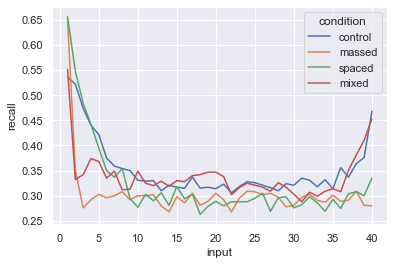

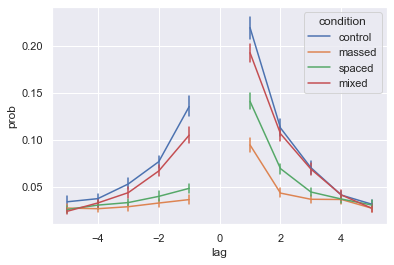

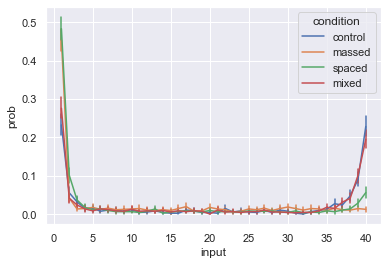

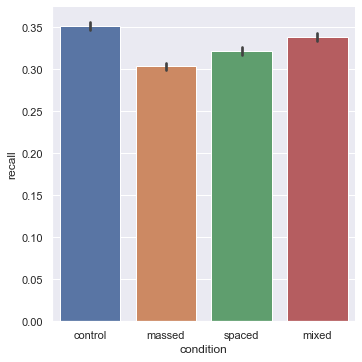

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

sns.lineplot(data=spc, x='input', y='recall', err_style='bars', hue='condition', legend=True, ci=False)
plt.show()

max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(data=lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='condition', legend=False)
sns.lineplot(data=lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='condition', legend=True)
plt.show()

sns.lineplot(data=pfr, x='input', y='prob', err_style='bars', hue='condition', legend=True)
plt.show()

sns.catplot(data=spc, x='condition', y='recall', kind='bar')
plt.show()


## Overall

In [66]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_rep_objective_function(
    trials, presentations, list_types, list_length,
    {'sampling_rule': 0}, free_parameters)

overall_cmr_result = differential_evolution(cost_function, bounds, disp=False)
print(overall_cmr_result.fun)

60842.741460287456


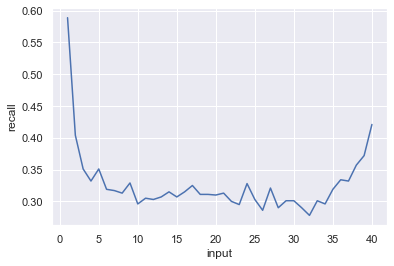

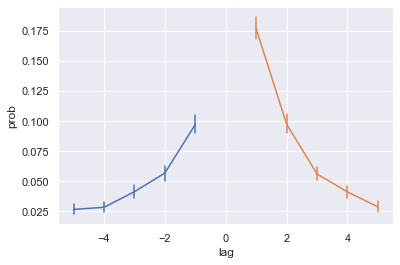

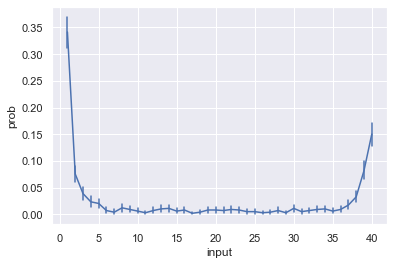

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

model = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_result.x[i] for i in range(len(overall_cmr_result.x))}})

sim_df = simulate_data(model, 1000)

spc = fr.spc(sim_df)
lag_crp = fr.lag_crp(sim_df)
pfr = fr.pnr(sim_df)
pfr = pfr.query('output <= 1')

sns.lineplot(data=spc, x='input', y='recall', err_style='bars', legend=True, ci=False)
plt.show()

max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(data=lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars',  legend=False)
sns.lineplot(data=lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars',  legend=True)
plt.show()

sns.lineplot(data=pfr, x='input', y='prob', err_style='bars', legend=True)
plt.show()
